In [1]:
from pathlib import Path
from typing import Tuple
import numpy as np
import pandas as pd
import torch
import gpytorch
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from rich.progress import Progress, SpinnerColumn, TextColumn

from analytical_models.gde_multi import System
from analytical_models import gde_multi
from analytical_models.loaders import load_data

In [2]:
X, y, means, stds, df = load_data()
df.head()

(90, 5) (90, 2)


,AgCu Ratio,Naf vol (ul),Sust vol (ul),Zero_eps_thickness,Catalyst mass loading,FE (Eth),FE (CO)
0,0.5,900,900,0.000005,15.5,0.1915,0.044284
1,0.5,900,900,0.000005,16.6,0.1816,0.052081
2,0.5,900,900,0.000006,18.9,0.1891,0.036053
3,1.0,0,0,0.000004,13.1,0.0048,0.393515
4,1.0,0,0,0.000004,15.0,0.0028,0.358907


In [3]:
def get_cov(batch):
    batch = batch.reshape(*batch.shape[:-2], -1)
    return torch.cov(batch.transpose(-1,-2)) + 1e-6*torch.eye(batch.shape[1])

def get_nll(predictions, targets):
    samples = predictions.sample(sample_shape=torch.Size([1000]))
    return get_nll_samples(samples, targets)

def get_nll_samples(samples, targets):
    gmodel = gpytorch.distributions.MultitaskMultivariateNormal(mean=samples.mean(dim=0), covariance_matrix=get_cov(samples))
    return -(gmodel.log_prob(targets) / gmodel.event_shape.numel()).item()

In [4]:
class PhModel(torch.nn.Module):
    def __init__(
        self, 
        zlt_mu_stds: Tuple,
        current_target: float = 200,
        dropout: float = 0.1, 
        ldim: int = 64,
    ):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(5, ldim),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(ldim, ldim),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(ldim, ldim),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(ldim, 6)
        )

        erc = gde_multi.electrode_reaction_kinetics | {}
        erc['i_0_CO'] = torch.nn.parameter.Parameter(torch.tensor(erc['i_0_CO']))
        erc['i_0_C2H4'] = torch.nn.parameter.Parameter(torch.tensor(erc['i_0_C2H4']))
        erc['i_0_H2b'] = torch.nn.parameter.Parameter(torch.tensor(erc['i_0_H2b']))
        erc['alpha_CO'] = torch.nn.parameter.Parameter(torch.tensor(erc['alpha_CO']))
        erc['alpha_C2H4'] = torch.nn.parameter.Parameter(torch.tensor(erc['alpha_C2H4']))
        erc['alpha_H2b'] = torch.nn.parameter.Parameter(torch.tensor(erc['alpha_H2b']))
        self.ph_model = System(
            diffusion_coefficients=gde_multi.diffusion_coefficients, 
            salting_out_exponents=gde_multi.salting_out_exponents, 
            electrode_reaction_kinetics=erc,
            electrode_reaction_potentials=gde_multi.electrode_reaction_potentials,
            chemical_reaction_rates=gde_multi.chemical_reaction_rates,
        )
        self.softmax = torch.nn.Softmax(dim=1)
        self.zlt_mu_stds = zlt_mu_stds
        self.current_target = current_target

    def forward(self, x):
        # columns of x: AgCu Ratio, Naf vol (ul), Sust vol (ul), Zero_eps_thickness, Catalyst mass loading
        latents = self.net(x)
        r = 40e-9 * torch.exp(latents[..., [0]])
        eps = torch.sigmoid(latents[..., [1]])
        zlt = (x[..., 3]*self.zlt_mu_stds[1] + self.zlt_mu_stds[0]).view(-1,1)
        L = zlt / (1 - eps)
        K_dl_factor = torch.exp(latents[..., [2]])
        thetas = self.softmax(2*latents[..., 3:])
        # CO activation must not be zero
        theta0 = thetas[...,[0]]
        theta1 = thetas[...,[1]]
        theta2 = thetas[...,[2]]
        thetas = {
            'CO': theta0,
            'C2H4': theta1,
            'H2b': theta2
        }
        gdl_mass_transfer_coefficient = K_dl_factor * self.ph_model.bruggeman(gde_multi.diffusion_coefficients['CO2'], eps) / r

        solution = self.ph_model.solve_current(
            i_target=self.current_target,
            eps=eps,
            r=r,
            L=L,
            thetas=thetas,
            gdl_mass_transfer_coeff=gdl_mass_transfer_coefficient,
            grid_size=1000,
            voltage_bounds=(-1.25,0)
        )
        out = torch.cat([solution['fe_c2h4'], solution['fe_co']], dim=-1)
        return out

In [5]:
def train_Ph_single(num_data_per_model: int, DNAME: str, disable_progress=False):
    kf = KFold(5)

    DNAME = Path(DNAME)
    DNAME.mkdir(exist_ok=True)
    NUM_ITER = 200

    fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(15,3))
    for i in range(1,5):
        ax[i].axline([0.3, 0.3], slope=1, color='black', linestyle='--')


    with Progress(SpinnerColumn(), *Progress.get_default_columns(), TextColumn("{task.fields}"), disable=disable_progress) as progress:
        task1 = progress.add_task("[red]Leave one out...", total=kf.get_n_splits(X))
        task2 = progress.add_task("[green]Inner loop...", total=(NUM_ITER), loss=0, val_loss=0)

        def train_Ph_Model(i, train_index, test_index):
            progress.reset(task2)
            # data
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # set up model and optimizer
            model = PhModel(zlt_mu_stds=(means['Zero_eps_thickness'], stds['Zero_eps_thickness']), current_target=233)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

            model.train()

            stats = {x:np.nan for x in ['loss','val_loss']} | {'step':np.arange(NUM_ITER)}
            stats = pd.DataFrame(stats).set_index('step')


            for it in range(NUM_ITER):
                optimizer.zero_grad()

                output = model(X_train)
                loss = torch.nn.functional.mse_loss(output, y_train)

                loss.backward()
                optimizer.step()
                stats.loc[it, 'loss'] = loss.item()

                # test            
                if it%10==0:

                    model.eval()

                    with torch.no_grad():
                        fe_train = model(X_train)    

                    with torch.no_grad():
                        fe_test = model(X_test)
                        val_loss = torch.nn.functional.mse_loss(fe_test, y_test).item()
                        val_error = torch.nn.functional.l1_loss(fe_test, y_test).item()
                        stats.loc[it, 'val_loss'] = val_loss
                        stats.loc[it, 'val_error'] = val_error         

                    model.train()


                progress.update(task2, advance=1, loss=loss.item(), val_loss=val_loss)

            # loss curves
            stats['loss'].dropna().plot(y='loss', c='C0', ls='--', lw=0.7, alpha=0.5, ax=ax[0])
            stats['val_loss'].dropna().plot(y='val_loss', c='C1', ls='--', lw=0.7, alpha=0.5, ax=ax[0])

            # plot parity plots with confidence intervals
            ax[1].scatter(y_train[:, 0].numpy(), fe_train[:,0].numpy(), alpha=0.5, fc=f'C{i}', ec='white')
            ax[2].scatter(y_test[:, 0].numpy(), fe_test[:, 0].numpy(), alpha=0.5, fc=f'C{i}', ec='white')
            ax[3].scatter(y_train[:, 1].numpy(), fe_train[:,1].numpy(), alpha=0.5, fc=f'C{i}', ec='white')
            ax[4].scatter(y_test[:, 1].numpy(), fe_test[:, 1].numpy(),  alpha=0.5, fc=f'C{i}', ec='white')

            # save average losses to file
            stats.to_csv(DNAME/f'stats_{i:02d}.csv')
            df_predictions = pd.concat([df.iloc[test_index].reset_index(), pd.DataFrame(fe_test.numpy(), columns=['Pred Eth', 'Pred CO'])])
            df_predictions.to_csv(DNAME/f'predictions_{i:02d}.csv', index=False)

            progress.update(task1, advance=1, i=i)

            return stats, model

        for i, (train_index, test_index) in enumerate(kf.split(X)):
            stats, model = train_Ph_Model(i, train_index, test_index)
            break # don't do the full K-fold validation here

    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('Loss')
    for i,l in enumerate(['Eth','CO']):
        ax[1+2*i].set_xlabel(f'True FE({l})')
        ax[1+2*i].set_ylabel(f'Predicted FE({l})')
        ax[2+2*i].set_xlabel(f'True FE({l})')
        ax[2+2*i].set_ylabel(f'Predicted FE({l})')


    plt.tight_layout()
    plt.savefig(DNAME/f'allplots.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f'Average negative val loss with N={num_data_per_model}')
    res = []
    for f in Path(DNAME).glob('stats*.csv'):
        _df = pd.read_csv(f)
        res.append(_df['val_loss'].dropna().iloc[-1])
        
    avg_nll = np.mean(res)
    print(avg_nll)
    return avg_nll, model

Output()

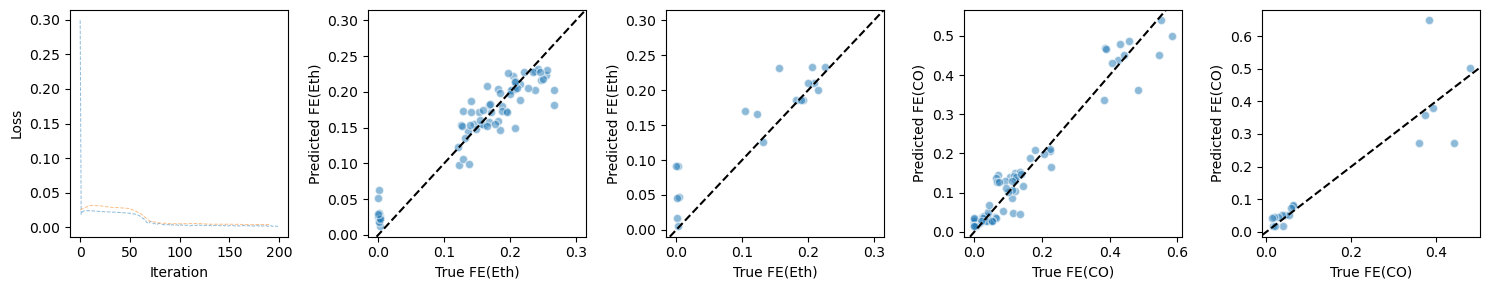

Average negative val loss with N=30
0.0040109241381287


In [6]:
nll, model = train_Ph_single(30, 'Ph_S1')

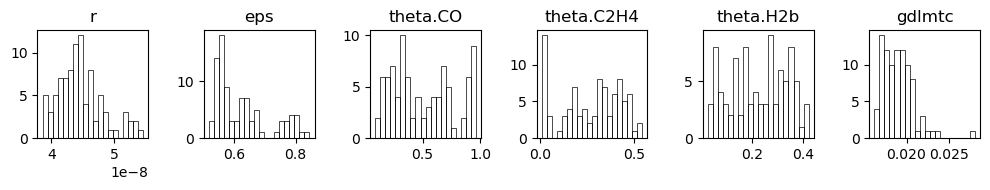

In [7]:
with torch.no_grad():
    latents = model.net(X)
    r = 40e-9 * torch.exp(latents[..., [0]])
    eps = torch.sigmoid(latents[..., [1]])
    zlt = (X[..., 3]*model.zlt_mu_stds[1] + model.zlt_mu_stds[0]).view(-1,1)
    L = zlt / (1 - eps)
    K_dl_factor = torch.exp(latents[..., [2]])
    thetas = model.softmax(2*latents[..., 3:])
    # CO activation must not be zero
    theta0 = thetas[...,[0]]
    theta1 = thetas[...,[1]]
    theta2 = thetas[...,[2]]
    thetas = {
        'CO': theta0,
        'C2H4': theta1,
        'H2b': theta2
    }
    gdl_mass_transfer_coefficient = K_dl_factor * model.ph_model.bruggeman(gde_multi.diffusion_coefficients['CO2'], eps) / r
    
k = 0
fig, ax = plt.subplots(ncols=6, figsize=(10,2))
bin_args = dict(bins=20, ec='k', lw=0.5, fc='none')
plot_vars = {'r':r, 'eps':eps, 'theta':thetas, 'gdlmtc':gdl_mass_transfer_coefficient}
for name, v in plot_vars.items():
    if isinstance(v, torch.Tensor):
        ax[k].hist(v.flatten(), **bin_args)
        ax[k].set_title(name)
        k += 1
    elif isinstance(v, dict):
        for key, val in v.items():
            ax[k].hist(val.flatten(), **bin_args)
            ax[k].set_title(f'{name}.{key}')
            k += 1
            
fig.tight_layout()

In [8]:
def predict_coverage_with_uncertainty(model, x, niter: int = 200):
    preds = {'CO':[], 'C2H4':[], 'H2b':[], 'FE_CO':[], 'FE_Eth':[]}
    model.train()
    for i in range(niter):
        fe_pred = model(x)
        latents = model.net(x)
        r = 40e-9 * torch.exp(latents[..., [0]])
        eps = torch.sigmoid(latents[..., [1]])
        zlt = (x[..., 3]*model.zlt_mu_stds[1] + model.zlt_mu_stds[0]).view(-1,1)
        L = zlt / (1 - eps)
        K_dl_factor = torch.exp(latents[..., [2]])
        thetas = model.softmax(2*latents[..., 3:])
        # CO activation must not be zero
        theta0 = thetas[...,[0]]
        theta1 = thetas[...,[1]]
        theta2 = thetas[...,[2]]
        thetas = {
            'CO': theta0,
            'C2H4': theta1,
            'H2b': theta2
        }
        gdl_mass_transfer_coefficient = K_dl_factor * model.ph_model.bruggeman(gde_multi.diffusion_coefficients['CO2'], eps) / r

        for key, val in thetas.items():
            preds[key].append(val.detach().numpy())
        preds['FE_Eth'].append(fe_pred[:,[0]].detach().numpy())
        preds['FE_CO'].append(fe_pred[:,[1]].detach().numpy())
    for key in preds:
        preds[key] = np.concatenate(preds[key], axis=-1)
    return preds

In [9]:
x = torch.zeros(51, X.shape[1])
agcu = torch.linspace(0, 1, x.shape[0])
agcu_normed = (agcu - means['AgCu Ratio']) / stds['AgCu Ratio']
x[:, 0] = agcu_normed
preds = predict_coverage_with_uncertainty(model, x)

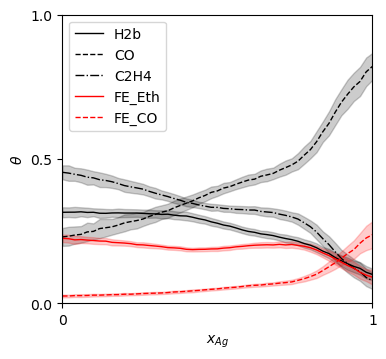

In [10]:
mu = {key:np.mean(val, axis=-1) for key, val in preds.items()}
std = {key:np.std(val, axis=-1) for key, val in preds.items()}
colors = ['k','k','k']
ls = ['-', '--','-.']

fig, ax = plt.subplots(figsize=(4,3.75))
for i, key in enumerate(['H2b', 'CO', 'C2H4']):
    plt.fill_between(agcu, mu[key]-std[key], mu[key]+std[key], alpha=0.2, color=colors[i], fc='k')
    plt.plot(agcu, mu[key], c=colors[i], ls=ls[i], lw=1, label=key)
for i, key in enumerate(['FE_Eth', 'FE_CO']):
    plt.fill_between(agcu, mu[key]-std[key], mu[key]+std[key], alpha=0.2, color='r', fc='r')
    plt.plot(agcu, mu[key], c='r', ls=ls[i], lw=1, label=key)
    

plt.legend()
plt.xlim(0,1)    
plt.ylim(0,1)
plt.yticks([0,0.5,1])
plt.xticks([0,1])
plt.ylabel(r'$\theta$')
plt.xlabel(r'$x_{Ag}$')
plt.savefig('xag_2.pdf', bbox_inches='tight', pad_inches=0.1)